# 数据探索性分析与数据预处理

**张煦阳 3220230979**

选取数据集来源：[Github Dataset](https://www.kaggle.com/datasets/nikhil25803/github-dataset?select=repository_data.csv)

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
from matplotlib.gridspec import GridSpec

# ===== DRAW FUNCTIONS ===== #

def draw_boxplot(data: dict, title: str):
    plt.grid()
    plt.boxplot(list(data.values()),
                medianprops={"color": "red", "linewidth": "1.5"},
                meanline=True,
                showmeans=True,
                meanprops={"color": "blue", "linewidth": "1.5", "ls": "--"},
                flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 2},
                labels=list(data.keys()))
    all_nums = [num for sublist in data.values() for num in sublist]
    bottomV = min(all_nums)
    topV = max(all_nums)
    gap = (topV - bottomV) / 10
    plt.yticks(np.arange(bottomV - gap, topV + gap, gap))
    plt.title(title)
    
def draw_table(data: dict):
    column_width = {name: max(max([len(str(v)) for v in array]) + 2, len(name)) for name, array in data.items()}
    table_height = max([len(ls) for ls in data.values()])
    row_line = '+'
    header_line = '|'
    content_lines = ['|' for f in range(table_height)]
    for name, width in column_width.items():
        row_line += f"{'-' * width}+"
        header_line += f"{str(name):^{width}}|"
        for idx, value in enumerate(data[name] + [""] * (table_height - len(data[name]))):
            content_lines[idx] += f"{str(value):^{width}}|"
    print(row_line)
    print(header_line)
    print(row_line)
    for row in content_lines:
        print(row)
    print(row_line)
    
# ===== STATISTIC FUNCTIONS ===== #

def count_frequency(dataset: list, handleEmpty=False):
    counter = {}
    for value in dataset:
        counter[value] = counter.setdefault(value, 0) + 1
    if handleEmpty:
        if '' in counter.keys():
            counter["(EMPTY)"] = counter.pop('')
    counter = {pair[0]:pair[1] for pair in sorted(counter.items(), key=lambda x:x[1], reverse=True)}
    return counter
    

## 1. 数据集分析报告（其一）

**数据来源：github_dataset.csv**

### 1.1 数据摘要和可视化

#### 1.1.1 数据摘要

In [2]:
path_0 = "./github_dataset.csv"
titles_0 = {}
dataset_0 = {}

with open(path_0, newline='') as csvfile:
    reader = csv.reader(csvfile)
    titles_0 = {idx:name for idx, name in enumerate(next(reader))}
    dataset_0 = {name:[] for idx, name in titles_0.items()}
    for row in reader:
        for idx, value in enumerate(row):
            dataset_0[titles_0[idx]].append(value)
            
    for idx, ls in enumerate(dataset_0.values()):
        if titles_0[idx] in ['repositories', 'language']:
            continue
        dataset_0[titles_0[idx]] = np.asarray(ls, dtype=int)
    
print(f"file: {path_0}\ntitles: {titles_0}\n")

file: ./github_dataset.csv
titles: {0: 'repositories', 1: 'stars_count', 2: 'forks_count', 3: 'issues_count', 4: 'pull_requests', 5: 'contributors', 6: 'language'}



+ 标称属性：language

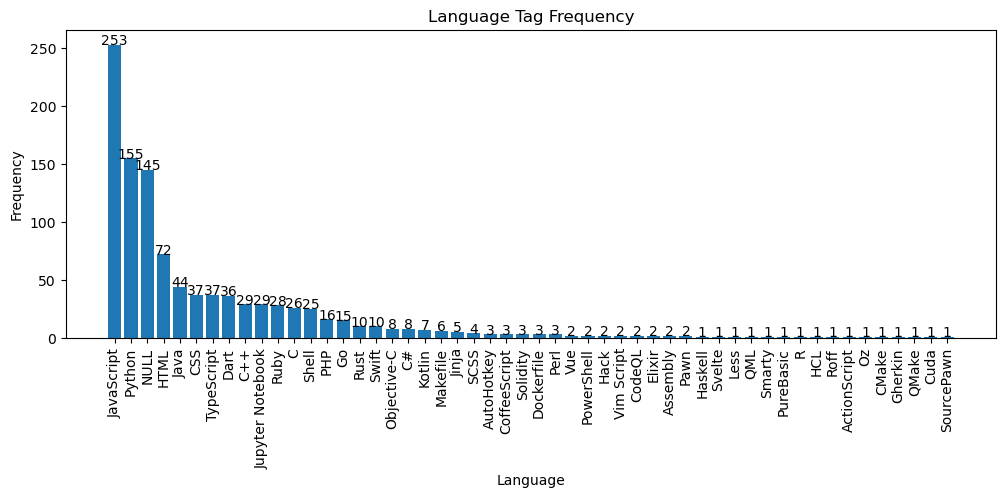

In [3]:
counter_language = {}

for value in dataset_0["language"]:
    counter_language[value] = counter_language.setdefault(value, 0) + 1
counter_language = {pair[0]:pair[1] for pair in sorted(counter_language.items(), key=lambda x:x[1], reverse=True)}
        
plt.figure(figsize=(12,4))
plt.bar(list(counter_language.keys()), list(counter_language.values()))
for idx, count in enumerate(counter_language.values()):
    plt.text(idx, count + 0.1, str(count), ha='center')
plt.title("Language Tag Frequency")
plt.xlabel("Language")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

+ 数值属性：stars_count、forks_count、issues_count、pull_requests、contributors

    （本数据集暂未发现缺失值）

In [4]:
digit_properties = {"property": [], "0%": [], "25%": [], "50%": [], "75%": [], "100%": []}
digit_properties['property'] += [name for name in dataset_0.keys() if name not in ['repositories', 'language']]
for name in digit_properties['property']:
    data_array = np.asarray(dataset_0[name], dtype=int)
    digit_properties["0%"].append(np.percentile(data_array, 0))
    digit_properties["25%"].append(np.percentile(data_array, 25))
    digit_properties["50%"].append(np.percentile(data_array, 50))
    digit_properties["75%"].append(np.percentile(data_array, 75))
    digit_properties["100%"].append(np.percentile(data_array, 100))
draw_table(digit_properties)

+---------------+-----+-----+------+-------+-------+
|   property    | 0%  | 25% | 50%  |  75%  | 100%  |
+---------------+-----+-----+------+-------+-------+
|  stars_count  | 0.0 | 1.0 | 12.0 | 65.25 | 995.0 |
|  forks_count  | 0.0 | 1.0 | 6.0  | 38.25 | 973.0 |
| issues_count  | 1.0 | 1.0 | 2.0  |  6.0  | 612.0 |
| pull_requests | 0.0 | 0.0 | 0.0  |  2.0  | 567.0 |
| contributors  | 0.0 | 0.0 | 2.0  |  4.0  | 658.0 |
+---------------+-----+-----+------+-------+-------+


#### 1.1.2 数据可视化

+ 包含全部数据的数值属性盒图、去除离群点的盒图，以及去除Q1、Q3之外数据的盒图

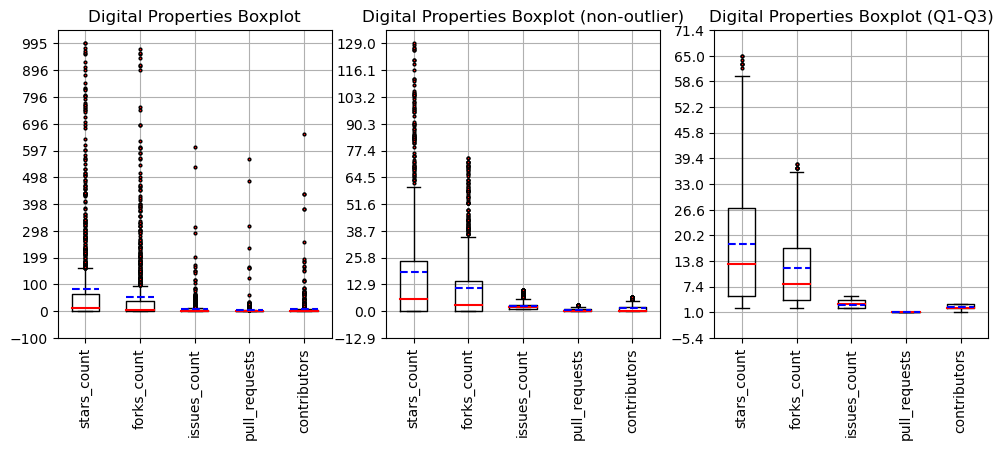

In [5]:
plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
plt.xticks(rotation=90)
draw_boxplot({name: ls for name, ls in dataset_0.items() if name not in ['repositories', 'language']}, "Digital Properties Boxplot")

plt.subplot(1, 3, 2)
cleaned_dataset = {}
for idx, vals in enumerate(dataset_0.values()):  # 寻找上下边界值
    if titles_0[idx] in ['repositories', 'language']:
        continue
    q1 = np.percentile(vals, 25)
    q3 = np.percentile(vals, 75)
    top = q3 + (q3 - q1) * 1
    bottom = q1 - (q3 - q1) * 1
    cleaned_dataset[titles_0[idx]] = [v for v in vals if bottom < v < top]
draw_boxplot(cleaned_dataset, "Digital Properties Boxplot (non-outlier)")
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
cleaned_dataset = {}
for idx, vals in enumerate(dataset_0.values()):  # 寻找上下边界值
    if titles_0[idx] in ['repositories', 'language']:
        continue
    q1 = np.percentile(vals, 25)
    q3 = np.percentile(vals, 75)
    cleaned_dataset[titles_0[idx]] = [v for v in vals if q1 < v < q3]
draw_boxplot(cleaned_dataset, "Digital Properties Boxplot (Q1-Q3)")
plt.xticks(rotation=90)

plt.show()

+ 直方图（所有数据）

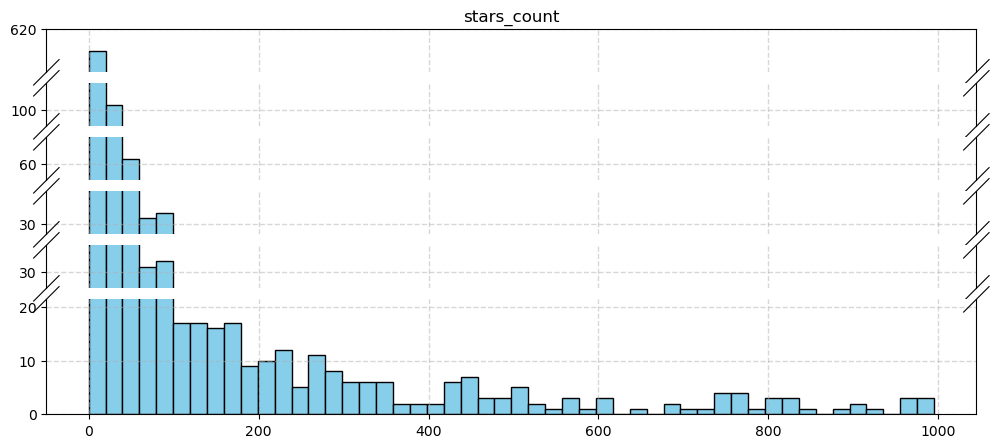

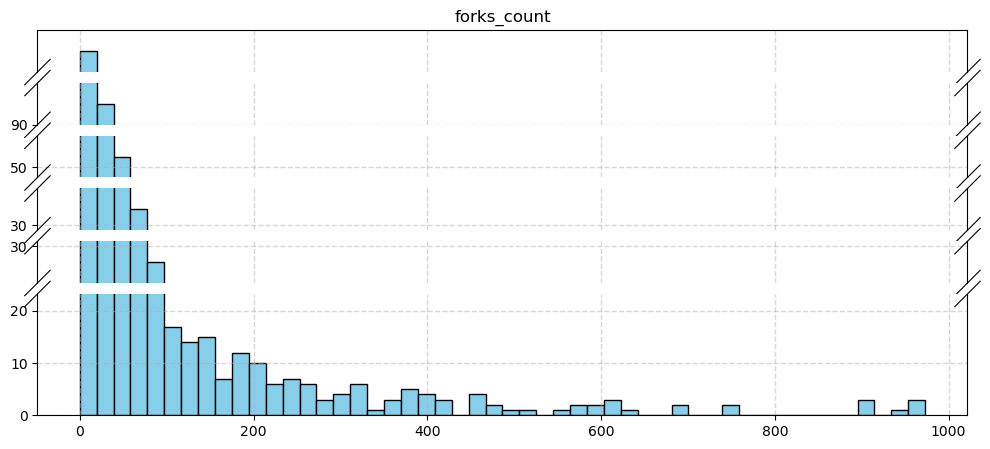

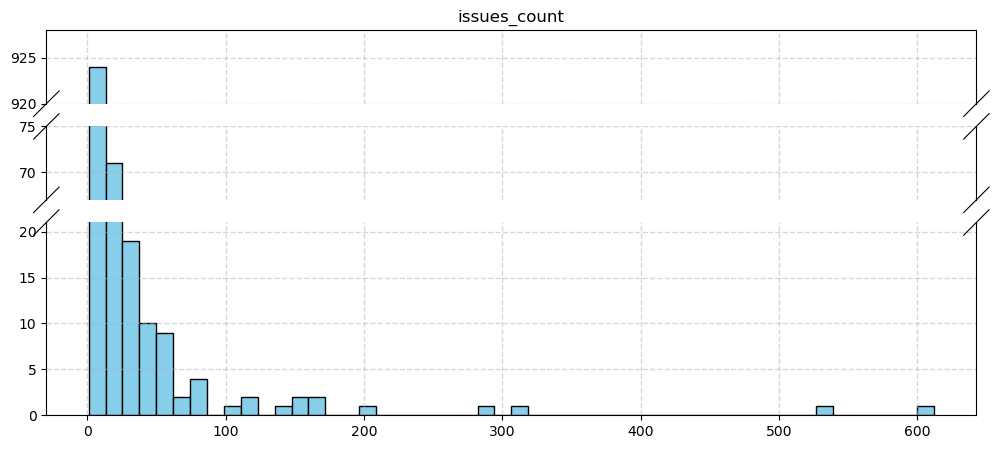

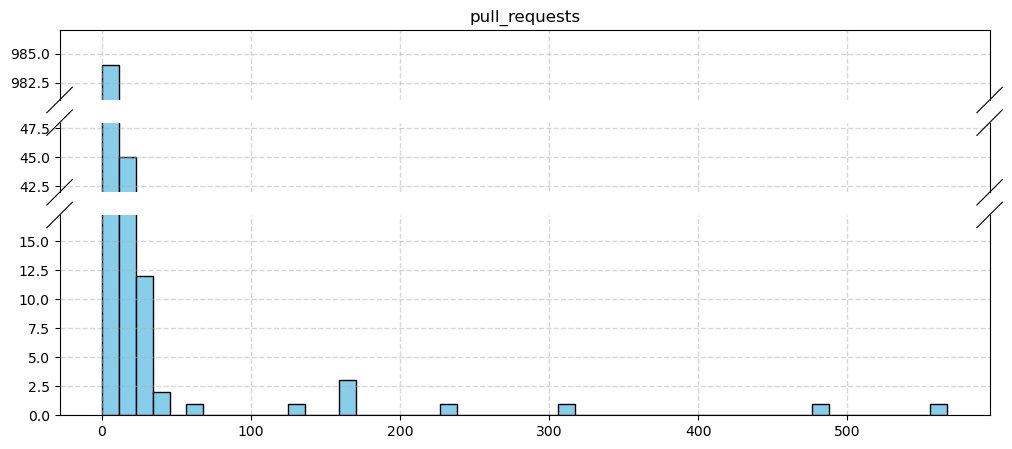

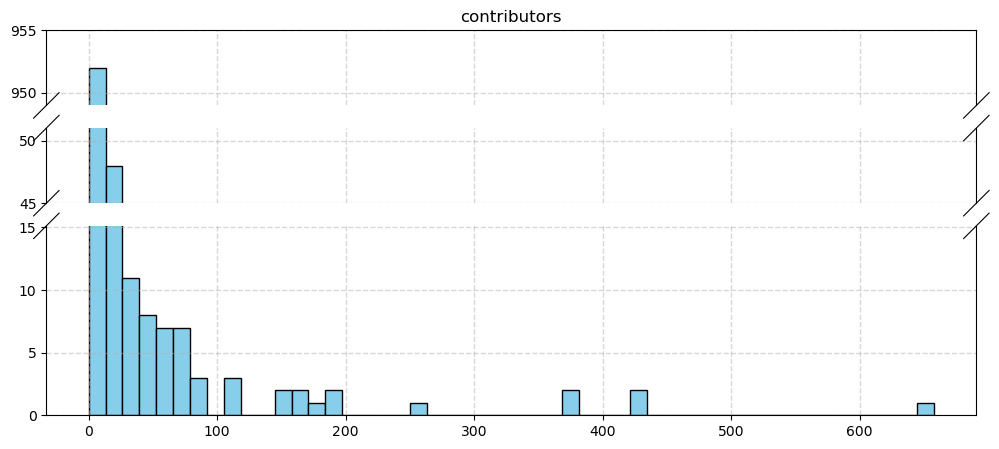

In [16]:
for idx, (name, data) in enumerate({name:ls for name, ls in dataset_0.items() if name not in ['repositories', 'language']}.items()):
    
    # 使用brokenaxes函数创建绘图坐标轴体系，ylim参数中输入断点两侧轴范围，
    # despine参数控制是否显示上轴和右轴，hspace参数控制断点截断线之间的宽度，d控制断点截断线的长度
    
    hist = plt.hist(data, bins=50)
    hist_count = [v for v in hist[0] if v > 0]
    q1 = np.percentile(hist_count, 25)
    q3 = np.percentile(hist_count, 75)
    top = q3 + (q3 - q1) * 1.5
    ylims = [(0, top)]
    for v in hist_count:
        if v > top:
            ylims.append((v - top//5, v + top//5))
    ylims = sorted(ylims, key=lambda x:x[0])
    plt.close()
    
    plt.figure(figsize=(12,5))
    ax = brokenaxes(ylims=tuple(ylims), despine=False)
    ax.hist(data, bins=50, color="skyblue", edgecolor="black")
    ax.grid(ls='--',alpha=0.5,linewidth=1)
    ax.set_title(name)
    ax.ticklabel_format(useOffset=False, style='plain')
    
    plt.show()

可见，本数据集的所有数据属性的大量数据均集中于较小水平，极少量数据数值极大，属于长尾分布。

### 1.2 数据缺失的处理

由于本数据集未出现数据缺失，故不做处理。

## 2. 数据集分析报告（其二）

**数据来源：repository_dataset.csv**

### 2.1 数据摘要和可视化

#### 2.1.1 数据摘要

In [8]:
path_1 = "./repository_data.csv"
titles_1 = {}
dataset_1 = {}

with open(path_1, newline='') as csvfile:
    reader = csv.reader(csvfile)
    titles_1 = {idx:name for idx, name in enumerate(next(reader))}
    dataset_1 = {name:[] for idx, name in titles_1.items()}
    
    for row in reader:
        for idx, value in enumerate(row):
            dataset_1[titles_1[idx]].append(value)
            
    for idx, ls in enumerate(dataset_1.values()):
        if titles_1[idx] in ['name', 'primary_language', 'languages_used', 'created_at', 'licence']:
            continue
        if type(ls[0]) is str:
            ls = [int(float(v)) if v != '' else -1 for v in ls]
        dataset_1[titles_1[idx]] = np.asarray(ls, dtype=int)
        
print(f"file: {path_1}\ntitles: {titles_1}\n")

file: ./repository_data.csv
titles: {0: 'name', 1: 'stars_count', 2: 'forks_count', 3: 'watchers', 4: 'pull_requests', 5: 'primary_language', 6: 'languages_used', 7: 'commit_count', 8: 'created_at', 9: 'licence'}



+ 标称属性：primary_language、languages_used、licence

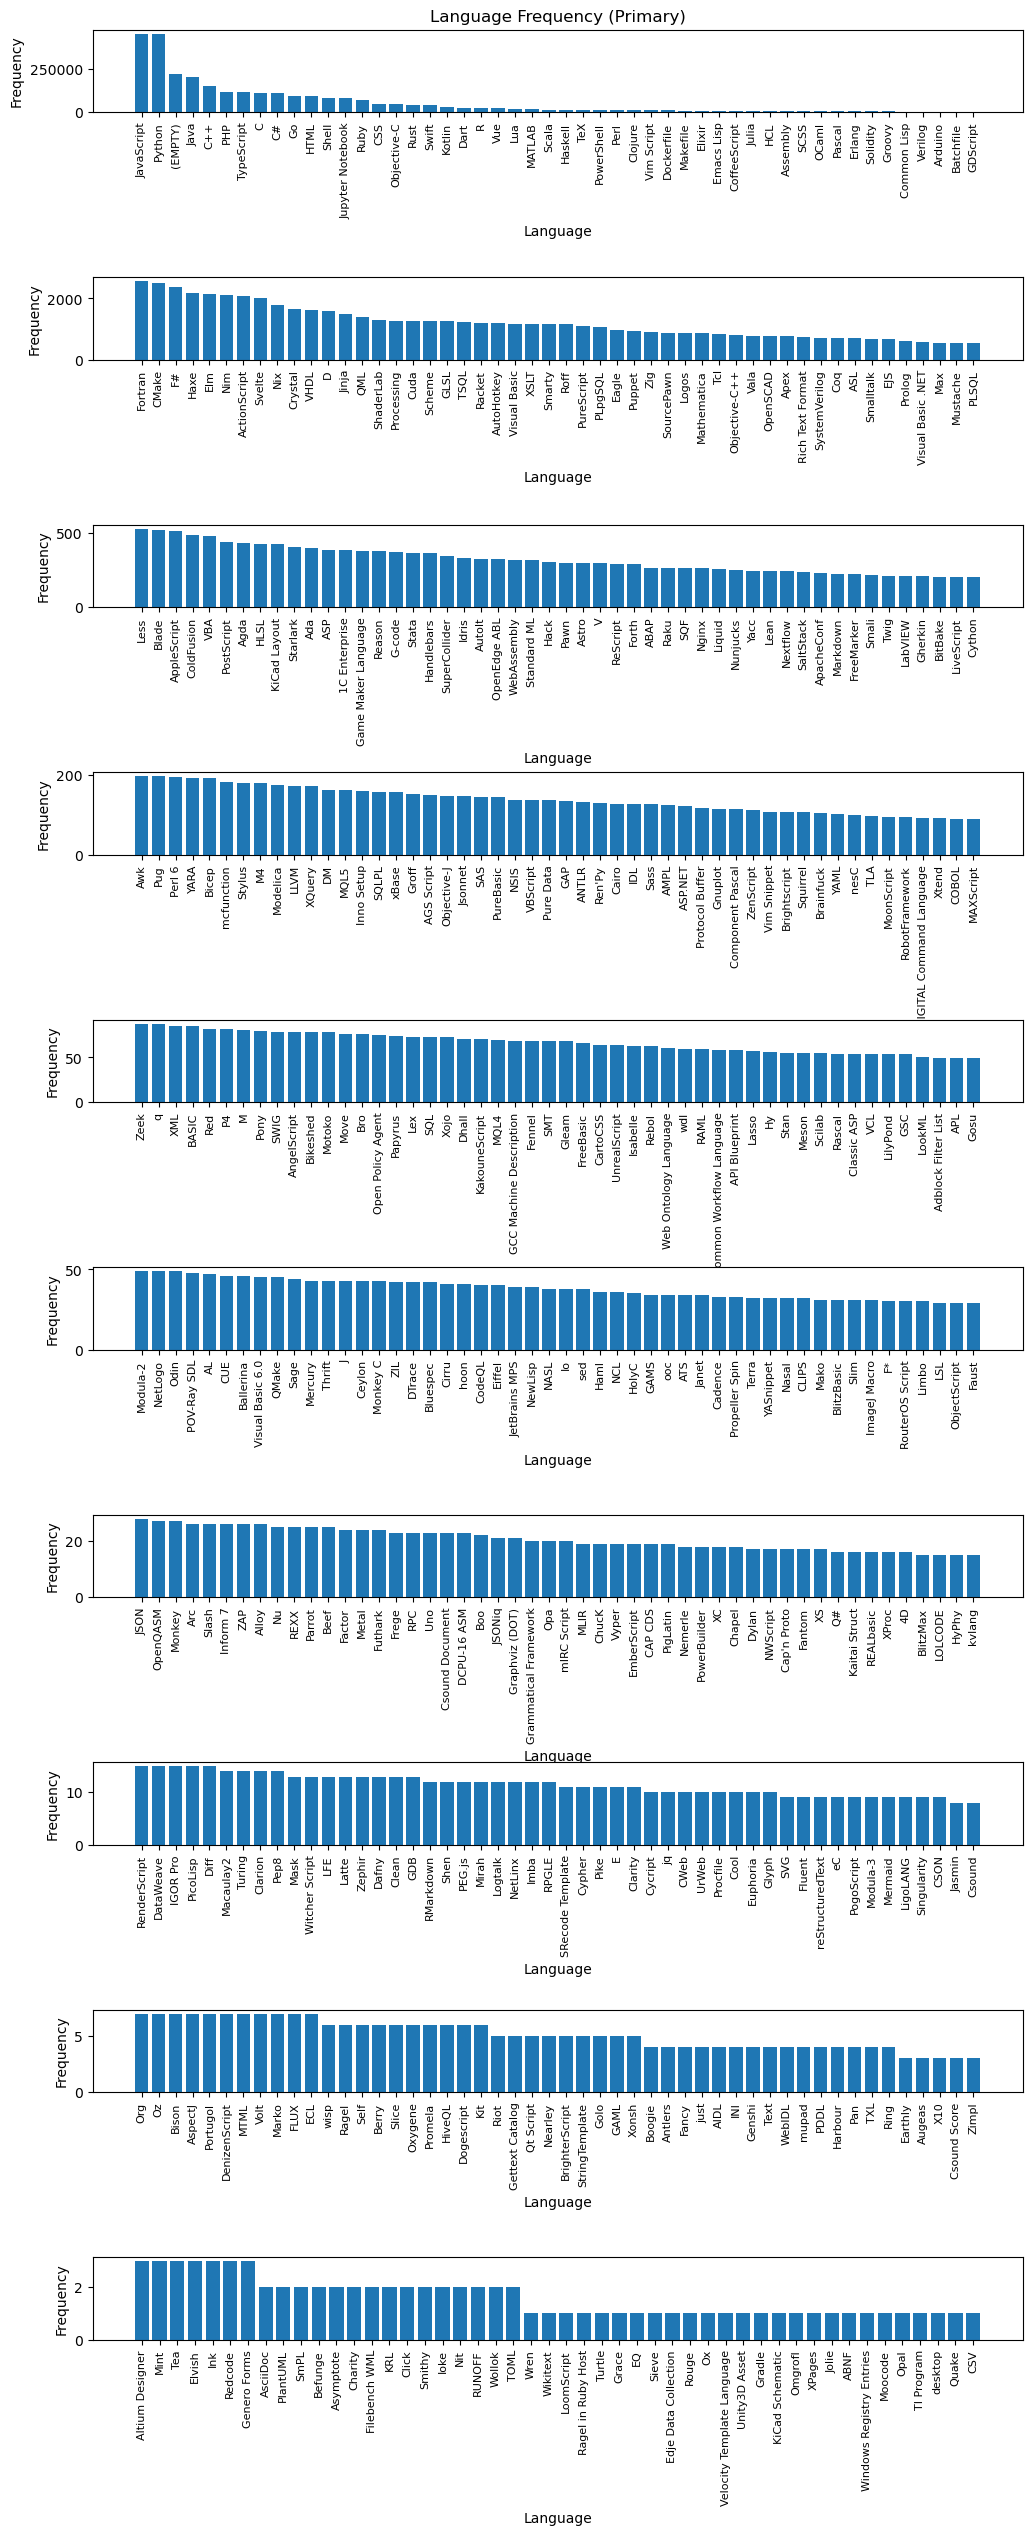

In [9]:
prime_language = {}

for value in dataset_1["primary_language"]:
    prime_language[value] = prime_language.setdefault(value, 0) + 1
if '' in prime_language.keys():
    prime_language["(EMPTY)"] = prime_language.pop('')
prime_language = {pair[0]:pair[1] for pair in sorted(prime_language.items(), key=lambda x:x[1], reverse=True)}
        
plt.figure(figsize=(12,30))

for idx in range(10):
    plt.subplot(10, 1, idx + 1)
    if (idx + 1)*50 <= len(prime_language.keys()):
        plt.bar(list(prime_language.keys())[idx*50:(idx+1)*50], list(prime_language.values())[idx*50:(idx+1)*50])
    else:
        plt.bar(list(prime_language.keys())[idx*50::], list(prime_language.values())[idx*50::])
    if idx == 0:
        plt.title("Language Frequency (Primary)")
    plt.xlabel("Language")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
    plt.xticks(fontsize=8)

plt.subplots_adjust(hspace=2)
plt.show()

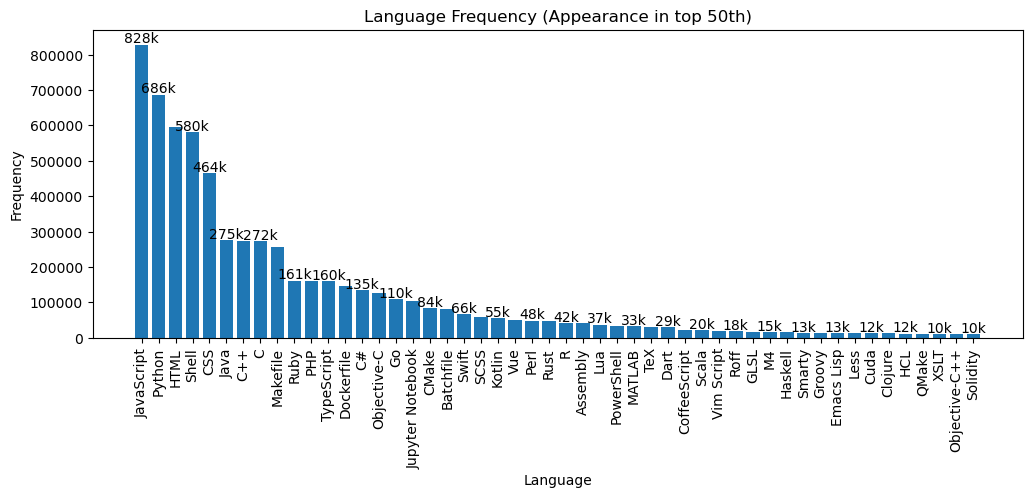

In [10]:
appeared_language = {}

for ls in dataset_1["languages_used"]:
    ls = eval(ls)if ls != '' else []
    for value in ls:
        appeared_language[value] = appeared_language.setdefault(value, 0) + 1
if '' in appeared_language.keys():
    appeared_language["(EMPTY)"] = appeared_language.pop('')
appeared_language = {pair[0]:pair[1] for pair in sorted(appeared_language.items(), key=lambda x:x[1], reverse=True)}

plt.figure(figsize=(12,4))
plt.bar(list(appeared_language.keys())[0:50], list(appeared_language.values())[0:50])
last_idx = -1
last_count = 10000000
for idx, count in enumerate(list(appeared_language.values())[0:50]):
    if idx - last_idx > 1 or last_count - count > 100000:
        plt.text(idx, count + 5000, str(f"{count // 1000}k"), ha='center')
        last_idx = idx
    last_count = count
plt.title("Language Frequency (Appearance in top 50th)")
plt.xlabel("Language")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

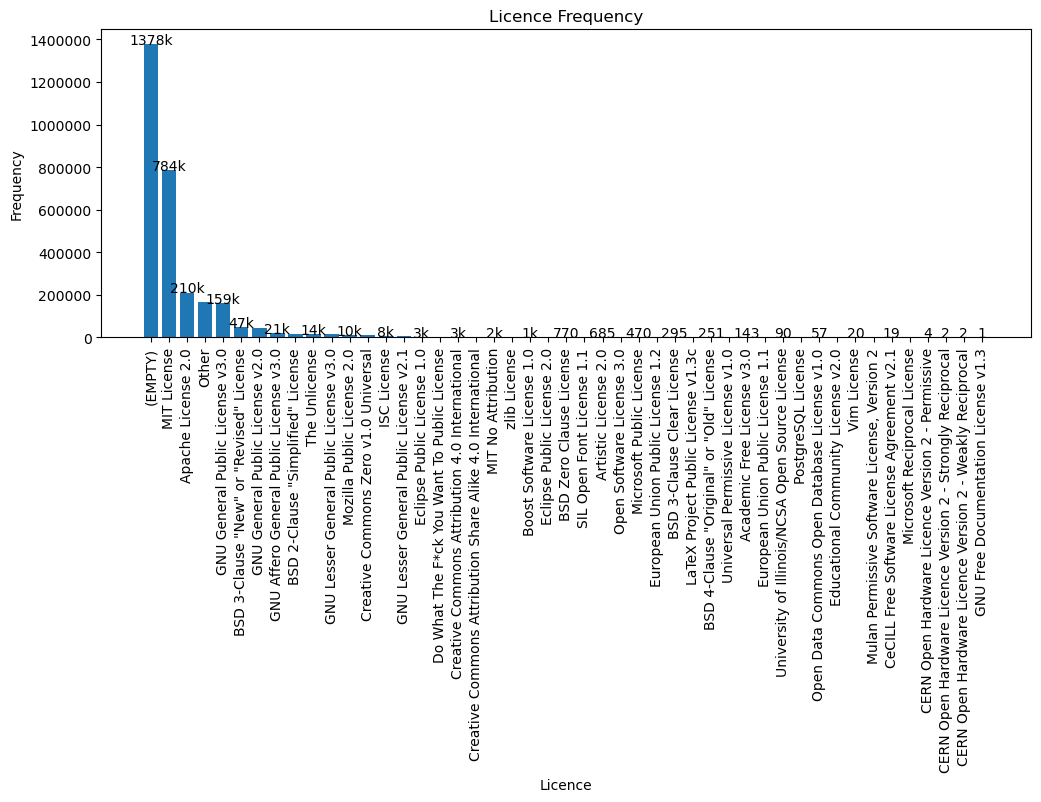

In [11]:
licences = count_frequency(dataset_1["licence"], handleEmpty=True)

plt.figure(figsize=(12,4))
plt.bar(list(licences.keys()), list(licences.values()))
last_idx = -1
last_count = 30000000
for idx, count in enumerate(list(licences.values())):
    if idx - last_idx > 1 or last_count - count > 100000 or count < 10:
        plt.text(idx, count, str(f"{str(count // 1000)+'k' if count > 1000 else count}"), ha='center')
        last_idx = idx
    last_count = count
plt.title("Licence Frequency")
plt.xlabel("Licence")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.gca().yaxis.get_major_formatter().set_scientific(False)
plt.show()


+ 数值属性：stars_count、forks_count、watchers、pull_requests、commit_count

    （同上，本数据集的数值属性也未出现缺失值）

In [12]:
non_digit_names = ['name', 'primary_language', 'languages_used', 'created_at', 'licence']

digit_properties = {"property": [], "0%": [], "25%": [], "50%": [], "75%": [], "100%": []}
digit_properties['property'] += [name for name in dataset_1.keys() if name not in non_digit_names]
for name in digit_properties['property']:
    data_array = np.asarray(dataset_1[name], dtype=int)
    digit_properties["0%"].append(np.percentile(data_array, 0))
    digit_properties["25%"].append(np.percentile(data_array, 25))
    digit_properties["50%"].append(np.percentile(data_array, 50))
    digit_properties["75%"].append(np.percentile(data_array, 75))
    digit_properties["100%"].append(np.percentile(data_array, 100))
draw_table(digit_properties)

+---------------+------+-----+------+------+-----------+
|   property    |  0%  | 25% | 50%  | 75%  |   100%    |
+---------------+------+-----+------+------+-----------+
|  stars_count  | 2.0  | 7.0 | 12.0 | 30.0 | 359805.0  |
|  forks_count  | 0.0  | 1.0 | 4.0  | 11.0 | 242208.0  |
|   watchers    | 0.0  | 2.0 | 3.0  | 6.0  |  9544.0   |
| pull_requests | 0.0  | 0.0 | 1.0  | 6.0  | 301585.0  |
| commit_count  | -1.0 | 9.0 | 27.0 | 89.0 | 4314502.0 |
+---------------+------+-----+------+------+-----------+


#### 2.1.2 数据可视化

+ 包含全部数据的数值属性盒图、去除离群点的盒图，以及去除Q1、Q3之外数据的盒图
    
    （为了显示清楚，第二行为数值较小的三组数据）

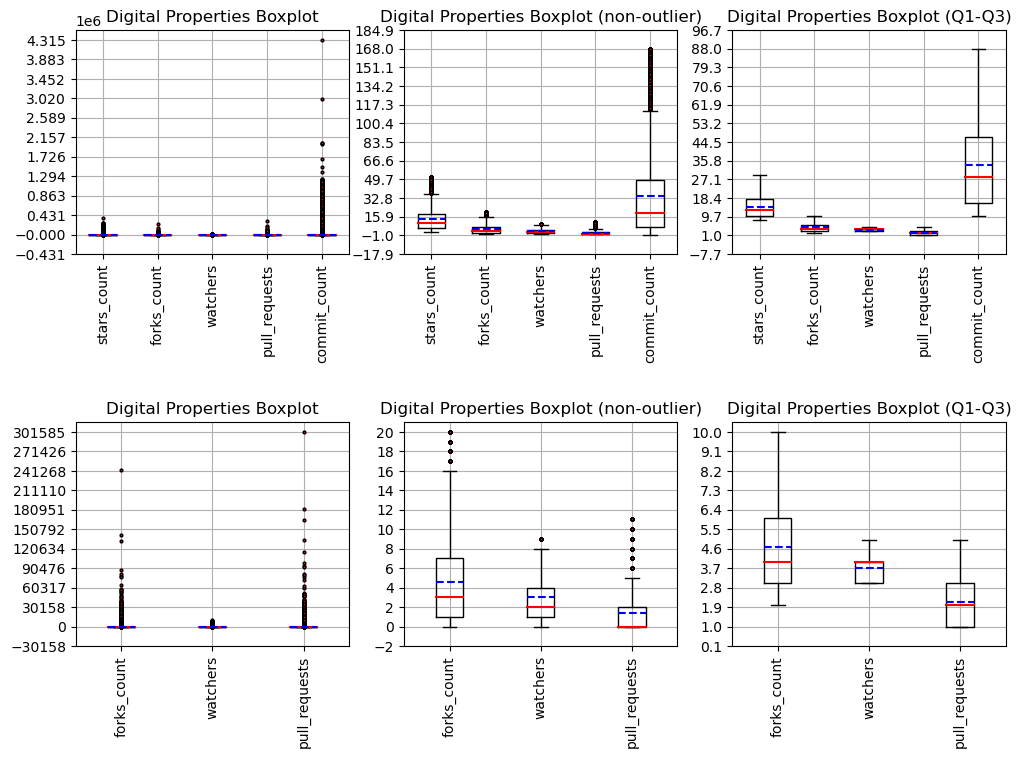

In [13]:
plt.figure(figsize=(12,8))

plt.subplot(2, 3, 1)
plt.xticks(rotation=90)
draw_boxplot({name: ls for name, ls in dataset_1.items() if name not in non_digit_names}, "Digital Properties Boxplot")

plt.subplot(2, 3, 2)
cleaned_dataset = {}
for idx, vals in enumerate(dataset_1.values()):  # 寻找上下边界值
    if titles_1[idx] in non_digit_names:
        continue
    q1 = np.percentile(vals, 25)
    q3 = np.percentile(vals, 75)
    top = q3 + (q3 - q1) * 1
    bottom = q1 - (q3 - q1) * 1
    cleaned_dataset[titles_1[idx]] = [v for v in vals if bottom < v < top]
draw_boxplot(cleaned_dataset, "Digital Properties Boxplot (non-outlier)")
plt.xticks(rotation=90)

plt.subplot(2, 3, 3)
cleaned_dataset = {}
for idx, vals in enumerate(dataset_1.values()):  # 寻找上下边界值
    if titles_1[idx] in non_digit_names:
        continue
    q1 = np.percentile(vals, 25)
    q3 = np.percentile(vals, 75)
    cleaned_dataset[titles_1[idx]] = [v for v in vals if q1 < v < q3]
draw_boxplot(cleaned_dataset, "Digital Properties Boxplot (Q1-Q3)")
plt.xticks(rotation=90)

plt.subplot(2, 3, 4)
plt.xticks(rotation=90)
draw_boxplot({name: ls for name, ls in dataset_1.items() if name not in non_digit_names + ['stars_count', 'commit_count']}, "Digital Properties Boxplot")

plt.subplot(2, 3, 5)
cleaned_dataset = {}
for idx, vals in enumerate(dataset_1.values()):  # 寻找上下边界值
    if titles_1[idx] in non_digit_names + ['stars_count', 'commit_count']:
        continue
    q1 = np.percentile(vals, 25)
    q3 = np.percentile(vals, 75)
    top = q3 + (q3 - q1) * 1
    bottom = q1 - (q3 - q1) * 1
    cleaned_dataset[titles_1[idx]] = [v for v in vals if bottom < v < top]
draw_boxplot(cleaned_dataset, "Digital Properties Boxplot (non-outlier)")
plt.xticks(rotation=90)

plt.subplot(2, 3, 6)
cleaned_dataset = {}
for idx, vals in enumerate(dataset_1.values()):  # 寻找上下边界值
    if titles_1[idx] in non_digit_names + ['stars_count', 'commit_count']:
        continue
    q1 = np.percentile(vals, 25)
    q3 = np.percentile(vals, 75)
    cleaned_dataset[titles_1[idx]] = [v for v in vals if q1 < v < q3]
draw_boxplot(cleaned_dataset, "Digital Properties Boxplot (Q1-Q3)")
plt.xticks(rotation=90)

plt.subplots_adjust(hspace=0.75)
plt.show()

+ 直方图（所有数据）

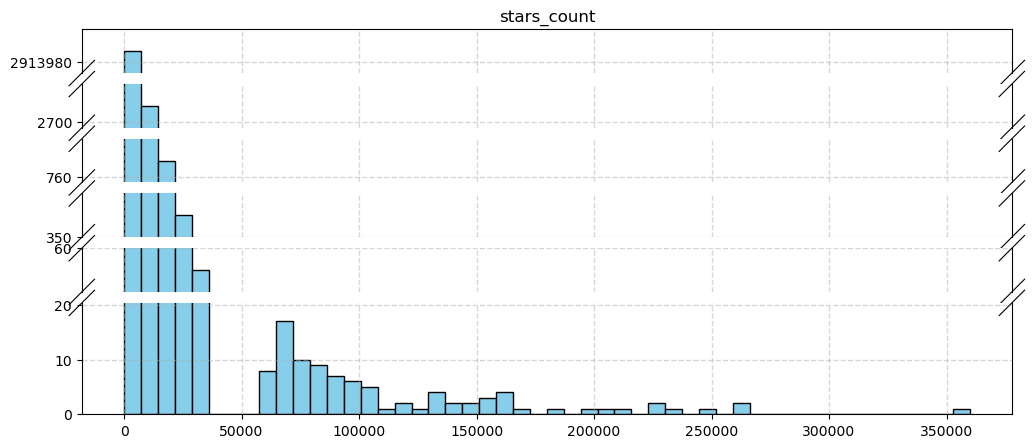

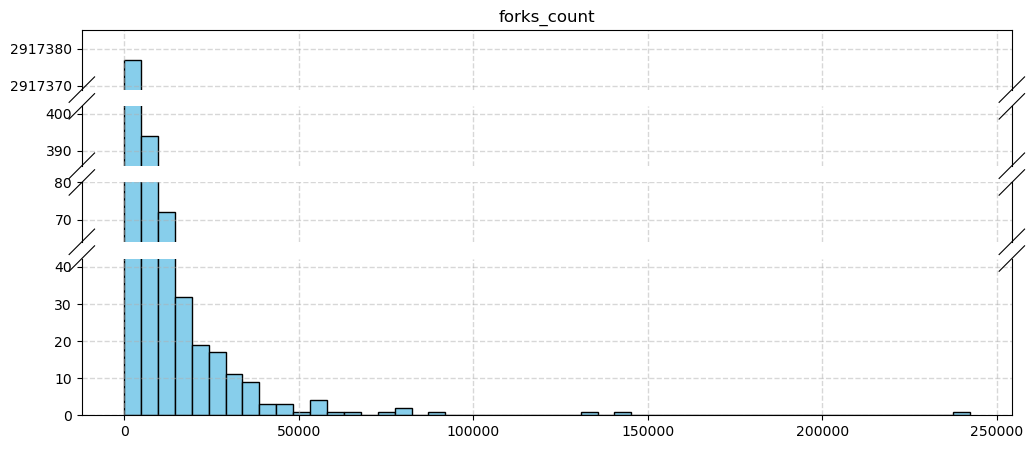

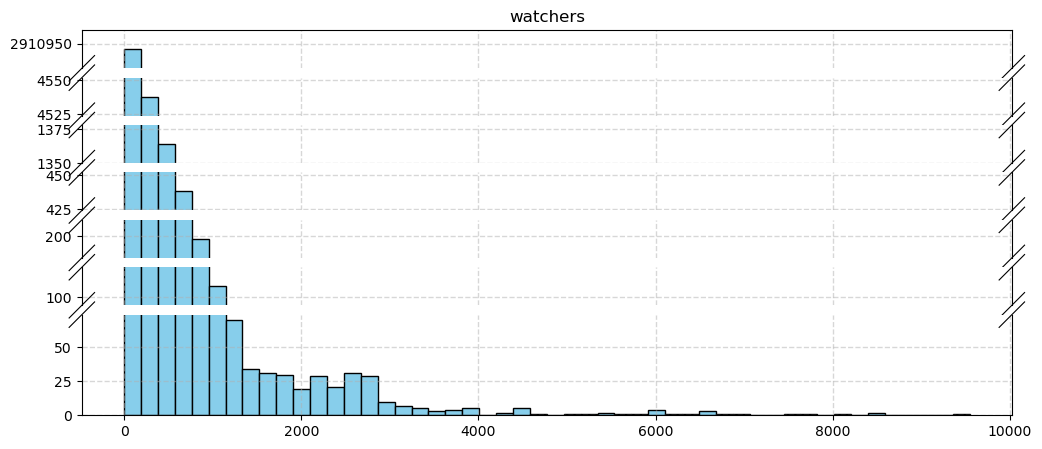

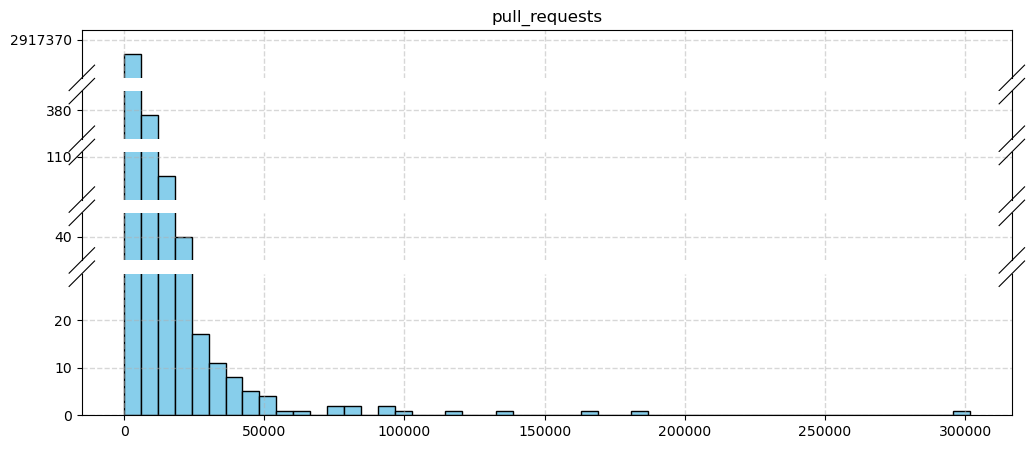

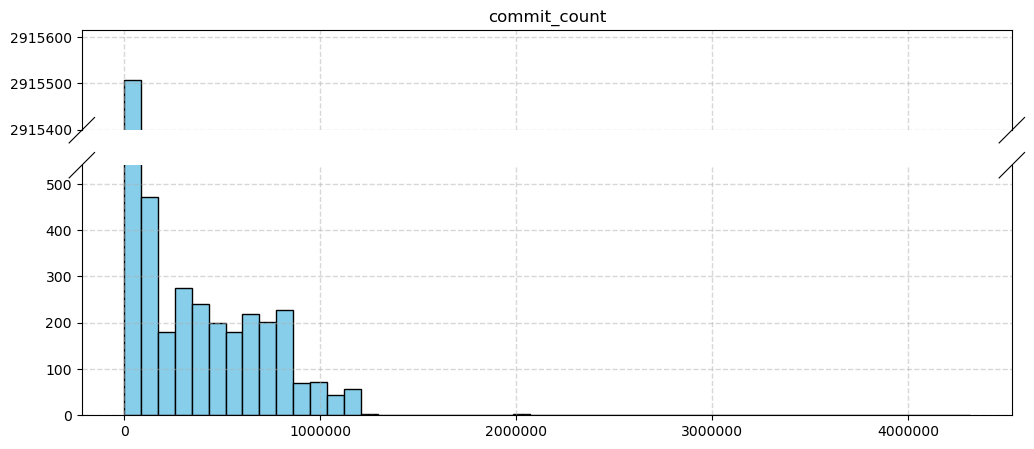

In [14]:
for idx, (name, data) in enumerate({name:ls for name, ls in dataset_1.items() if name not in non_digit_names}.items()):
    
    # 使用brokenaxes函数创建绘图坐标轴体系，ylim参数中输入断点两侧轴范围，
    # despine参数控制是否显示上轴和右轴，hspace参数控制断点截断线之间的宽度，d控制断点截断线的长度
    
    hist = plt.hist(data, bins=50)
    hist_count = [v for v in hist[0] if v > 0]
    q1 = np.percentile(hist_count, 25)
    q3 = np.percentile(hist_count, 75)
    top = q3 + (q3 - q1) * 1.5
    ylims = [(0, top)]
    for v in hist_count:
        if v > top:
            ylims.append((v - top//5, v + top//5))
    ylims = sorted(ylims, key=lambda x:x[0])
    plt.close()
    
    plt.figure(figsize=(12,5))
    ax = brokenaxes(ylims=tuple(ylims), despine=False)
    ax.hist(data, bins=50, color="skyblue", edgecolor="black")
    ax.grid(ls='--',alpha=0.5,linewidth=1)
    ax.set_title(name)
    ax.ticklabel_format(useOffset=False, style='plain')
    
    plt.show()

可见，Github数据集的数据分布相对较极端，极大量的极低数值和极少量的极大数值同时存在，是十分典型的**长尾分布**。

### 2.2 数据缺失的处理

同上，Github数据集的数值属性均无缺失值。而在此数据集中，语言的使用存在大量缺失值。不过，这种缺失是十分合理的，因为Github不仅作为代码托管仓而存在，不少用户还将它作为百科、资料库、资讯发布页等其他形式进行使用，故而不存在编程语言一说。